# Location Set Covering Problem

In [1]:
from spopt.locate.coverage import LSCP
from spopt.locate.util import simulated_geo_points

In [3]:
import numpy as np 
import geopandas as gpd 
import pulp 
import spaghetti 
from shapely.geometry import Point 
import matplotlib.pyplot as plt 
import osmnx as ox

In [128]:
patients = 175
medical_centers = 4
service_area = 5000
patient_seed = 54323
medical_centers_seed = 54323

In [129]:
solver = pulp.PULP_CBC_CMD(msg=False, warmStart=True)

In [6]:
G = ox.graph_from_place('Washington, DC', network_type='drive')

In [49]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [50]:
gdf_edges.reset_index(inplace=True)

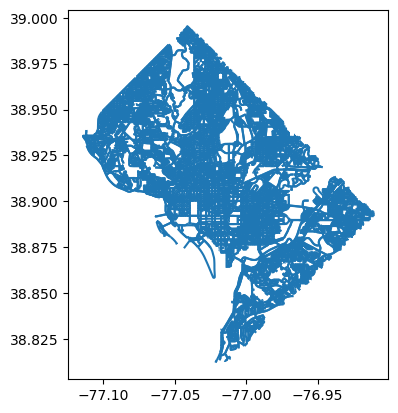

In [51]:
gdf_edges.plot();

>The next steps subset and reproject the data. Subsetting is necessary for large networks

In [52]:
DC_BGs = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_11_bg.zip')

In [53]:
DC_BGs_Sel = DC_BGs[DC_BGs['TRACTCE'].isin(['980000','010202','005900','000102','000202',
                                            '010800','005801','005802','010500','005602',
                                           '006600','008200'])]


In [54]:
DC_BGs_Sel_D = DC_BGs_Sel.dissolve()

In [55]:
DC_BGs_Sel_D = DC_BGs_Sel_D.to_crs('EPSG:4326')

In [56]:
mask = gdf_edges.within(DC_BGs_Sel_D.loc[0,'geometry'])
gdf_edges_clipped = gdf_edges.loc[mask]

<Axes: >

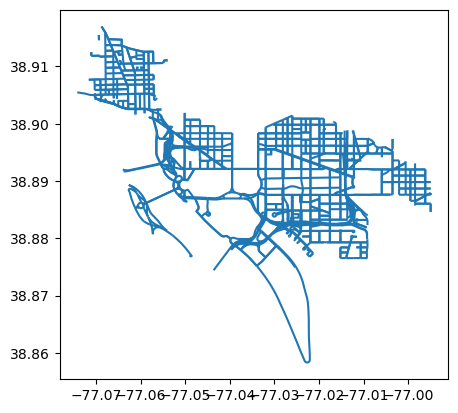

In [57]:
gdf_edges_clipped.plot()

In [58]:
gdf_edges_clipped = gdf_edges_clipped[['osmid','geometry']]

# Converting to the Albers projection
gdf_edges_clipped_p = gdf_edges_clipped.to_crs(5070)

In [59]:
ntw = spaghetti.Network(in_data=gdf_edges_clipped_p)

/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/spaghetti/network.py:946: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = weights.W(neighbors, **weights_kws)
/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/spaghetti/network.py:946: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: (2587, 2590).
  w = weights.W(neighbors, **weights_kws)


In [60]:
streets_gpd = spaghetti.element_as_gdf(ntw, arcs=True)

In [61]:
# Also create a buffered version
street_buffer = gpd.GeoDataFrame(
    gpd.GeoSeries(streets_gpd.geometry.buffer(10).union_all()), 
    crs=streets_gpd.crs, columns=['geometry']
)

<Axes: >

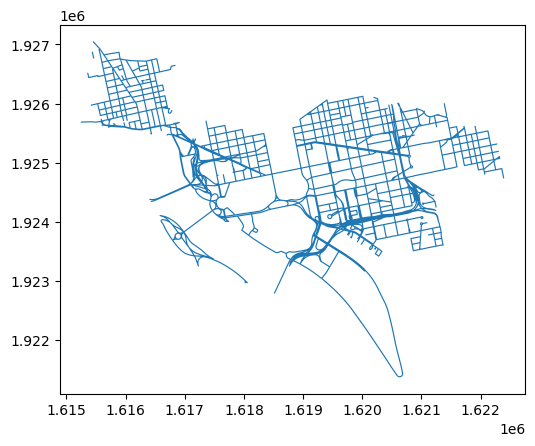

In [62]:
street_buffer.plot()

>Simulate patients and hospital locations

In [130]:
patient_locs = simulated_geo_points(street_buffer, 
                                   needed=patients, 
                                   seed=patient_seed)
medical_center_locs = simulated_geo_points(street_buffer, 
                                          needed=medical_centers, 
                                          seed=medical_centers_seed)

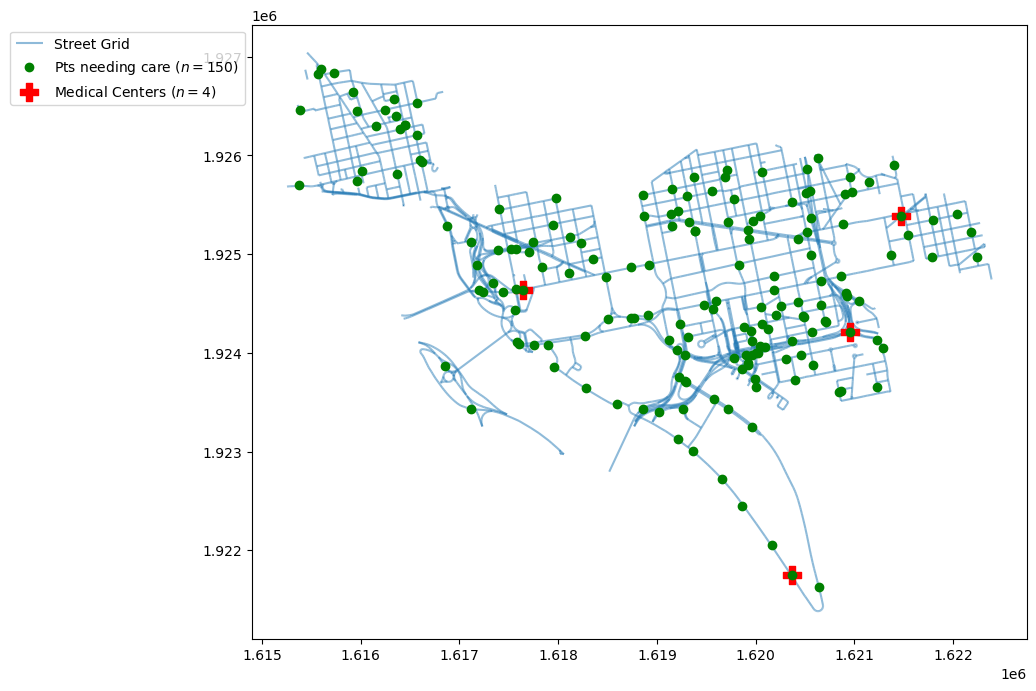

In [131]:
f, ax = plt.subplots(figsize=(10,10))
streets_gpd.plot(ax=ax, alpha=0.5, zorder=1, label='Street Grid')
patient_locs.plot(ax=ax, color='g', zorder=2, label='Pts needing care ($n=150$)')
medical_center_locs.plot(ax=ax, markersize=150, color='r', marker='P', 
                        label="Medical Centers ($n=4$)")
plt.legend(loc='upper right', bbox_to_anchor=(0,1));

>The locations must be snapped to the network

In [132]:
ntw.snapobservations(patient_locs, "patients", attribute=True)

/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


In [133]:
patients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name='patients', snapped=True
)

In [134]:
ntw.snapobservations(medical_center_locs, "medical_centers", 
                    attribute=True)
medical_centers_snapped = spaghetti.element_as_gdf(
    ntw, pp_name='medical_centers', snapped=True
)

/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/home/biscotty/Learning/AppliedGeospatial/_build/pip_packages/lib/python3.12/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


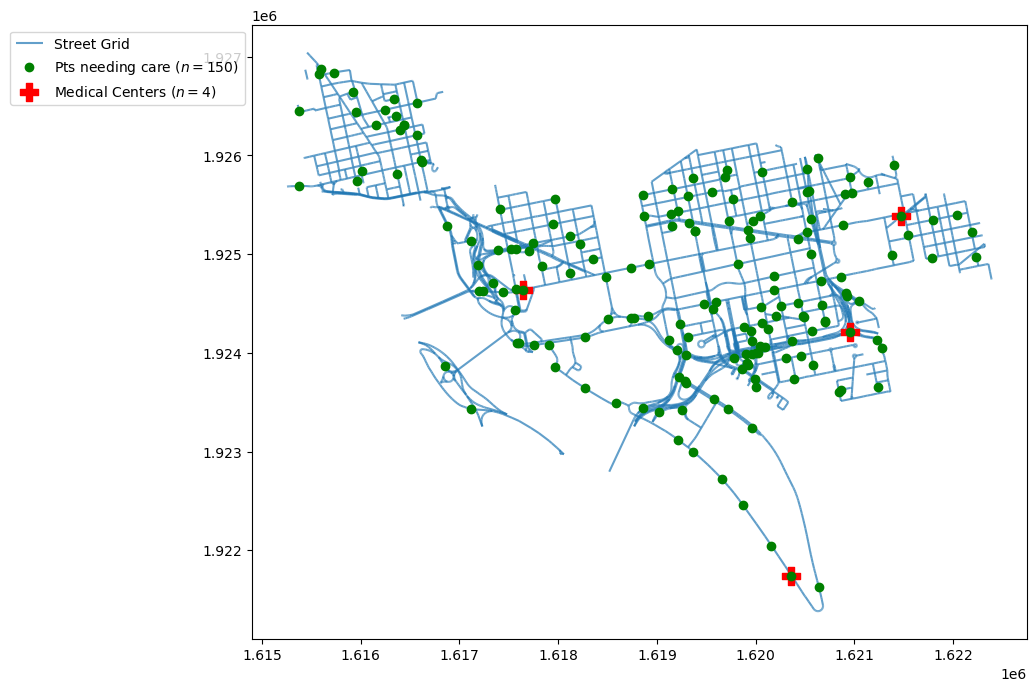

In [135]:
f, ax = plt.subplots(figsize=(10,10))
streets_gpd.plot(ax=ax, alpha=0.7, zorder=1, label='Street Grid')
patients_snapped.plot(ax=ax, color='g', zorder=2, label='Pts needing care ($n=150$)')
medical_centers_snapped.plot(ax=ax, markersize=150, color='r', marker='P', 
                        label="Medical Centers ($n=4$)")
plt.legend(loc='upper right', bbox_to_anchor=(0,1));

>Calculate the distance-cost matrix

In [136]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns['patients'], 
    destpattern=ntw.pointpatterns['medical_centers']
)

>Find the solution to the LSCP

In [137]:
lscp_from_cost_matrix = LSCP.from_cost_matrix(cost_matrix, service_area)

In [138]:
lscp_from_cost_matrix = lscp_from_cost_matrix.solve(solver)

In [139]:
lscp_from_cost_matrix.facility_client_array()

In [140]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

colors_arr = [
    "darkslateblue",
    "forestgreen",
    "firebrick",
    "peachpuff",
    "saddlebrown",
    "cornflowerblue"    
]

colors_ops = { f"y{i}":colors_arr[i] for i in range(len(colors_arr))}

serviced_points = []
selected_sites = []

for i in range(medical_centers):
    if lscp_from_cost_matrix.fac2cli[i]:

        geom = patient_locs.iloc[lscp_from_cost_matrix.fac2cli[i]]['geometry']
        serviced_points.append(geom)
        selected_sites.append(i)


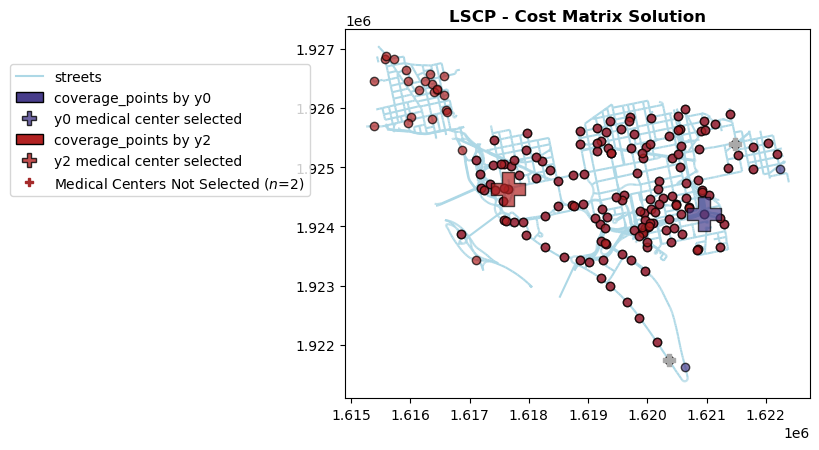

In [141]:
fig, ax = plt.subplots(figsize=(6, 6))
legend_elements = []

streets_gpd.plot(ax=ax, alpha=1, color='lightblue', zorder=1)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='lightblue',
    label='streets',
))

for i in range(len(serviced_points)):
    gdf = gpd.GeoDataFrame(serviced_points[i])

    l = f"y{selected_sites[i]}"

    label = f"coverage_points by y{selected_sites[i]}"
    legend_elements.append(Patch(facecolor=colors_ops[l], edgecolor="k", label=label))

    gdf.plot(ax=ax, zorder=3, alpha=0.7, edgecolor="k", color=colors_ops[l], label=label)
    medical_center_locs.iloc[[selected_sites[i]]].plot(ax=ax,
                            marker="P",
                            markersize=150 * 4.0,
                            alpha=0.7,
                            zorder=4,
                            edgecolor="k",
                            facecolor=colors_ops[l])

    legend_elements.append(mlines.Line2D(
        [],
        [],
        color=colors_ops[l],
        marker="P",
        ms=20 / 2,
        markeredgecolor="k",
        linewidth=0,
        alpha=0.8,
        label=f"y{selected_sites[i]} medical center selected",
    ))
    
mc_not_selected = medical_center_locs.drop(selected_sites)
mc_not_selected.plot(ax=ax, color='darkgrey', marker="P", markersize=80, zorder=3)
legend_elements.append(mlines.Line2D(
    [],
    [],
    color='brown',
    marker="P",
    linewidth=0,
    label=f'Medical Centers Not Selected ($n$={len(mc_not_selected)})'
))


plt.title("LSCP - Cost Matrix Solution", fontweight="bold")
plt.legend(handles = legend_elements, loc='upper right', bbox_to_anchor=(0,1), borderaxespad=2.5)
